# Query the database

In [1]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, text, inspect, func

# data
import pandas as pd
import numpy as np

# viz
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
SQL_USERNAME = 'postgres'
SQL_PASSWORD = 'postgres'
SQL_IP = 'localhost'
SQL_PORT = '5432'
SQL_DBNAME = 'crowdfunding_db'

In [3]:
# connect to database
connection_string = f"postgresql+psycopg2://{SQL_USERNAME}:{SQL_PASSWORD}@{SQL_IP}:{SQL_PORT}/{SQL_DBNAME}"
engine = create_engine(connection_string)

In [4]:
# explore and understand the data

# Create the inspector and connect it to the engine
inspector = inspect(engine)

# Collect the names of tables within the database
tables = inspector.get_table_names()

# Using the inspector to print the column names within each table and its types
for table in tables:
    print(table)
    columns = inspector.get_columns(table)
    for column in columns:
        print(column["name"], column["type"])
        
    print()

contacts
contact_id INTEGER
first_name VARCHAR(20)
last_name VARCHAR(20)
email VARCHAR(50)
last_updated TIMESTAMP

campaigns
cf_id INTEGER
contact_id INTEGER
company_name VARCHAR(50)
description VARCHAR(75)
goal INTEGER
pledged INTEGER
outcome VARCHAR(10)
backers_count INTEGER
country VARCHAR(2)
currency VARCHAR(3)
launched_date DATE
end_date DATE
category_id VARCHAR(4)
subcategory_id VARCHAR(10)
last_updated TIMESTAMP

categories
category_id VARCHAR(4)
category VARCHAR(20)
last_updated TIMESTAMP

sub_categories
subcategory_id VARCHAR(10)
subcategory VARCHAR(20)
last_updated TIMESTAMP



In [5]:
# Declare a Base using `automap_base()`
Base = automap_base()
# Use the Base class to reflect the database tables
Base.prepare(autoload_with=engine)

In [6]:
# Print all of the classes mapped to the Base
Base.classes.keys()

['categories', 'campaigns', 'sub_categories', 'contacts']

In [7]:
# save references to each table
Contacts = Base.classes.contacts
SubCategories = Base.classes.sub_categories
Campaigns = Base.classes.campaigns
Categories = Base.classes.categories

In [8]:
# create a session
session = Session(engine)

In [9]:
# Find the total number of campaigns
results = session.query(func.count(Campaigns.cf_id)).one()
results[0]

1000

In [11]:
# Find the number of campaigns by category
results = session.query(Categories.category, func.count(Campaigns.cf_id)).\
    join(Campaigns, Categories.category_id == Campaigns.category_id).\
    group_by(Categories.category).\
    order_by(func.count(Campaigns.cf_id).desc()).all()

category_counts = pd.DataFrame(results, columns=['category', 'count'])
category_counts.head()

,category,count
0,theater,344
1,film & video,178
2,music,175
3,technology,96
4,publishing,67


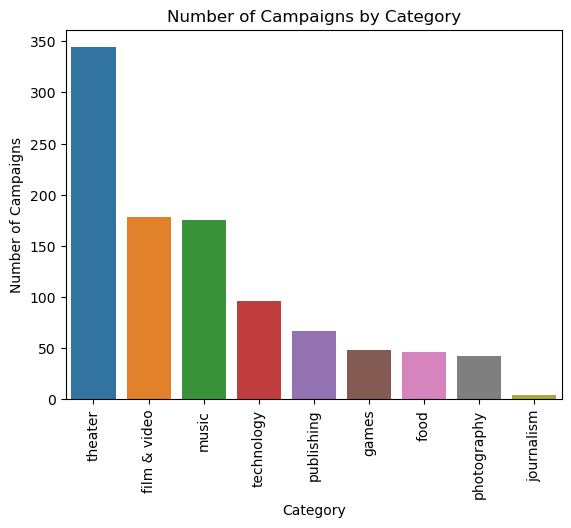

In [12]:
# Plot the number of campaigns by category
sns.barplot(x='category', y='count', data=category_counts)
plt.xlabel('Category')
plt.ylabel('Number of Campaigns')
plt.title('Number of Campaigns by Category')
plt.xticks(rotation=90)
plt.show()

In [ ]:
# close the session and kill the engine
session.close()
engine.dispose()